[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nthieu211/Vietnamese-Youtube-Comments-Sentiment/blob/main/Model/Emotion-Classification-Model.ipynb)

In [1]:
# Install nescessary library
!pip install -q transformers
!pip install -q emoji
!pip install -q underthesea
!pip install -q openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 61.9 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm
import regex as re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import underthesea
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel

In [3]:
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PRETRAINED_MODEL = 'vinai/phobert-base-v2'
DROPOUT = 0.4
EPOCHS = 8
N_SPLITS = 2
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
MAX_LEN = 120

Device: cuda


In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(42)

In [5]:
# Download PhoBERT model
phobert = AutoModel.from_pretrained(PRETRAINED_MODEL)
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

In [9]:
# Run on Colab
from google.colab import drive
drive.mount('/content/drive')

train_df = get_data('/content/drive/My Drive/DATASET-UIT-VSMEC/train_nor_811.xlsx')
valid_df = get_data('/content/drive/My Drive/DATASET-UIT-VSMEC/valid_nor_811.xlsx')
test_df = get_data('/content/drive/My Drive/DATASET-UIT-VSMEC/test_nor_811.xlsx')

Mounted at /content/drive


# Data analytics and preprocessing

In [10]:
train_df.head()

,Emotion,Sentence
0,Other,cho mình xin bài nhạc tên là gì với ạ
1,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


## Dataset info

In [11]:
print("Train shape = {}".format(train_df.shape))
print("Valid shape = {}".format(valid_df.shape))
print("Test shape = {}".format(test_df.shape))

Train shape = (5548, 2)
Valid shape = (686, 2)
Test shape = (693, 2)


In [12]:
train_df.info(), valid_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5548 entries, 0 to 5547
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   5548 non-null   object
 1   Sentence  5548 non-null   object
dtypes: object(2)
memory usage: 86.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   686 non-null    object
 1   Sentence  686 non-null    object
dtypes: object(2)
memory usage: 10.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


(None, None, None)

===> Not found missing value

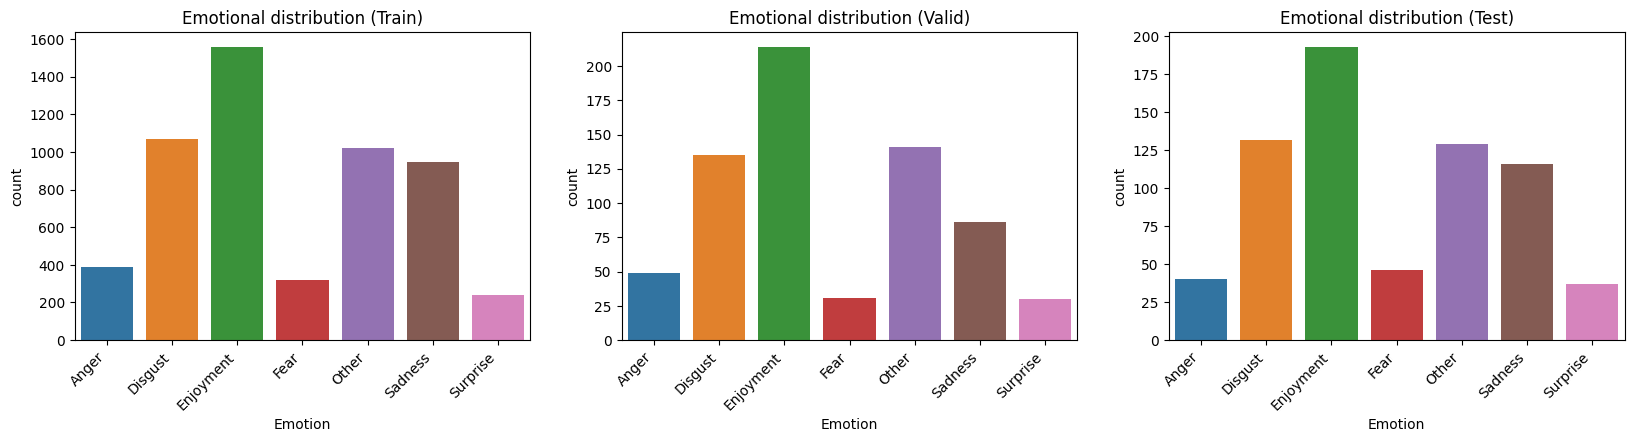

In [13]:
# Emotional distribution of dataset
emotional_labels = sorted(train_df['Emotion'].unique())
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
sns.countplot(x='Emotion', data=train_df, order=emotional_labels, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('Emotional distribution (Train)')

sns.countplot(x='Emotion', data=valid_df, order=emotional_labels, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title('Emotional distribution (Valid)')

sns.countplot(x='Emotion', data=test_df, order=emotional_labels, ax=axes[2])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_title('Emotional distribution (Test)')

plt.show()

===> Imbalanced. Weights should be added to the model

## Pre-processing text

Reference: https://github.com/nguyenvanhieuvn/text-classification-tutorial/blob/master/text_classification_tutorial.ipynb

In [14]:
# Remove HTML code
def remove_HTML(text):
    return re.sub(r'<[^>]*>', '', text)

In [15]:
# Standardize unicode
def convert_unicode(text):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')

    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], text
    )

In [16]:
# Standardize accent typing
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]

for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)


def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True


def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)


def standardize_sentence_typing(text):
    words = text.lower().split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

In [17]:
# Normalize acronyms
!rm -rf teencode.txt
!wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt

replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'ô kê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'cười', 'hehe': 'cười', 'hihi': 'cười', 'haha': 'cười', 'hjhj': 'cười', 'thick': 'thích',
    'cc': 'chửi tục', 'huhu': 'khóc', 'cute': 'dễ thương', 'cặc':'chửi tục', 'dm':'chửi tục', 'dmm':'chửi tục', 'dume':'chửi tục',

    'sz': 'cỡ', 'size': 'cỡ',
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'sốp': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'sgk':'sách giáo khoa', 'cv':'công việc',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'excelent': 'hoàn hảo', 'bt': 'bình thường', 'bth': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài',

    '^_^': 'cười', ':)': 'mỉm cười', ':(': 'buồn', '=))': 'cười',
    '❤️': 'yêu thích', '👍': 'thích', '🎉': 'chúc mừng', '😀': 'cười', '😍': 'yêu thích', '😂': 'cười chảy nước mắt', '🤗': 'vỗ tay', '😙': 'cười', '🙂': 'mỉm cười',
    '😔': 'buồn', '😓': 'buồn', 'T_T': 'khóc', '😭': 'khóc lớn',
    '⭐': 'star', '*': 'star', '🌟': 'star',
}

with open('teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()


def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        if word.lower() not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word.lower()])
    return emoji.demojize(' '.join(words)) # Remove Emojis

--2023-08-31 15:50:22--  https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: ‘teencode.txt’

teencode.txt        100%[===================>]   5.52K  --.-KB/s    in 0s      

2023-08-31 15:50:22 (66.4 MB/s) - ‘teencode.txt’ saved [5656/5656]



In [18]:
# Remove unnecessary characters
def remove_unnecessary_characters(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÉÈẺẼẸÊẾỀỂỄỆÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÍÌỈĨỊÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴĐ_]', ' ', text)
    text = re.sub(r"[\.,\?]+$-", "", text)
    text = text.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

In [19]:
# Word segmentation & Tokenize
def word_segmentation(line):
    return underthesea.word_tokenize(line, format="text")

In [20]:
def text_preprocess(text):
    text = remove_HTML(text)
    text = convert_unicode(text)
    text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) # required for PhoBERT
    text = remove_unnecessary_characters(text)
    return text

In [21]:
# Test function text_preprocess
print(f"Before: {train_df.iloc[32, 1]}")
print(f"After: {text_preprocess(train_df.iloc[32, 1])}")

Before: hồi học lớp 5 bảo bố đi mua sgk cho , xong bố đi mua nguyên bộ lớp 4 đầy đủ từ sgk đến vở bài tập 😂
After: hồi học lớp 5 bảo bố đi mua sách_giáo_khoa cho xong bố đi mua nguyên_bộ lớp 4 đầy_đủ từ sách_giáo_khoa đến vở bài_tập cười chảy nước_mắt


# Prepare training data

In [22]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=MAX_LEN):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Enjoyment':
            return 0
        elif text=='Disgust':
            return 1
        elif text=='Sadness':
            return 2
        elif text=='Anger':
            return 3
        elif text=='Surprise':
            return 4
        elif text=='Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        text = row['Sentence']
        text = text_preprocess(text)
        label = self.labelencoder(row['Emotion'])

        return text, label

# Model

In [23]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = phobert
        self.drop = nn.Dropout(p=DROPOUT)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

## Train & Eval Function

In [24]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0
    all_preds = []
    all_targets = []

    loader_bar = tqdm(train_loader, desc='Train', position=0, leave=True)

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        loader_bar.set_postfix({'loss': np.mean(losses)})
        loader_bar.update()

    accuracy = correct.double() / len(train_loader.dataset)
    f1 = f1_score(all_targets, all_preds, average='weighted')

    print(f'Train Accuracy: {accuracy:.4f}  -  Loss: {np.mean(losses):.4f}  -  F1-Score: {f1:.4f}')

    return accuracy, f1

In [25]:
def eval(test_data=False):
    model.eval()
    losses = []
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        loader_bar = tqdm(data_loader, desc=('Test' if test_data else 'Valid'), position=0, leave=True)
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            loader_bar.set_postfix({'loss': np.mean(losses)})
            loader_bar.update()

    accuracy = correct.double() / len(data_loader.dataset)
    f1 = f1_score(all_targets, all_preds, average='weighted')

    if test_data:
        print(f'Test Accuracy: {accuracy:.4f}  -  Loss: {np.mean(losses):.4f}  -  F1-Score: {f1:.4f}')
    else:
        print(f'Valid Accuracy: {accuracy:.4f}  -  Loss: {np.mean(losses):.4f}  -  F1-Score: {f1:.4f}')

    return accuracy, f1

## Training k-fold

In [26]:
# Use Kfold - Cross-validation for training model
skf = StratifiedKFold(n_splits=N_SPLITS)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
    train_df.loc[val_idx, "kfold"] = fold
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'Sentence'].shape, train_df.loc[val_idx, 'Sentence'].shape))
    print('Fold {} Training Set Unique Emotion Count = {} - Validation Set Unique Emotion Count = {}'.format(fold, train_df.loc[trn_idx, 'Emotion'].nunique(), train_df.loc[val_idx, 'Emotion'].nunique()))


Fold 0 Training Set Shape = (2774,) - Validation Set Shape = (2774,)
Fold 0 Training Set Unique Emotion Count = 7 - Validation Set Unique Emotion Count = 7

Fold 1 Training Set Shape = (2774,) - Validation Set Shape = (2774,)
Fold 1 Training Set Unique Emotion Count = 7 - Validation Set Unique Emotion Count = 7


In [27]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=MAX_LEN)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [28]:
# Class weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced",
                                    classes = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other'],
                                    y = train_df['Emotion'])
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(class_weights)

tensor([0.5087, 0.7400, 0.8369, 2.0270, 3.2751, 2.4924, 0.7763])


In [29]:
# Training:
for fold in range(skf.n_splits):
    print(f'\n============ Fold: {fold+1} ============')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(device)
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps = (len(train_loader)*EPOCHS) // 10,
                num_training_steps = len(train_loader)*EPOCHS
            )
    best_acc = 0
    best_f1 = 0
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch+1}/{EPOCHS}')
        print('-'*50)

        train(model, criterion, optimizer, train_loader)
        val_acc, val_f1 = eval()

        if val_acc > best_acc and val_f1 > best_f1:
            torch.save(model, 'weights.pt')
            best_acc = val_acc
            best_f1 = val_f1
    print(f'\nBest accuracy: {best_acc:.4f}\tBest F1-score: {best_f1:.4f}')


============ Fold: 1 ============

Epoch 1/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:05<00:00,  2.66it/s, loss=2.03]


Train Accuracy: 0.2848  -  Loss: 2.0348  -  F1-Score: 0.1968


Valid: 100%|██████████| 174/174 [00:19<00:00,  8.82it/s, loss=1.78]


Valid Accuracy: 0.3554  -  Loss: 1.7815  -  F1-Score: 0.2566

Epoch 2/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.78it/s, loss=1.64]


Train Accuracy: 0.4189  -  Loss: 1.6401  -  F1-Score: 0.3971


Valid: 100%|██████████| 174/174 [00:19<00:00,  9.03it/s, loss=1.5]


Valid Accuracy: 0.4773  -  Loss: 1.5036  -  F1-Score: 0.4499

Epoch 3/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.76it/s, loss=1.31]


Train Accuracy: 0.5566  -  Loss: 1.3141  -  F1-Score: 0.5503


Valid: 100%|██████████| 174/174 [00:19<00:00,  9.11it/s, loss=1.29]


Valid Accuracy: 0.5671  -  Loss: 1.2889  -  F1-Score: 0.5705

Epoch 4/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:03<00:00,  2.76it/s, loss=1.03]


Train Accuracy: 0.6590  -  Loss: 1.0291  -  F1-Score: 0.6568


Valid: 100%|██████████| 174/174 [00:18<00:00,  9.22it/s, loss=1.2]


Valid Accuracy: 0.5440  -  Loss: 1.2022  -  F1-Score: 0.5539

Epoch 5/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.77it/s, loss=0.831]


Train Accuracy: 0.7325  -  Loss: 0.8305  -  F1-Score: 0.7318


Valid: 100%|██████████| 174/174 [00:19<00:00,  9.13it/s, loss=1.21]


Valid Accuracy: 0.5959  -  Loss: 1.2092  -  F1-Score: 0.6001

Epoch 6/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:03<00:00,  2.76it/s, loss=0.66]


Train Accuracy: 0.7934  -  Loss: 0.6603  -  F1-Score: 0.7920


Valid: 100%|██████████| 174/174 [00:19<00:00,  9.11it/s, loss=1.2]


Valid Accuracy: 0.6053  -  Loss: 1.1959  -  F1-Score: 0.6040

Epoch 7/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.77it/s, loss=0.56]


Train Accuracy: 0.8335  -  Loss: 0.5599  -  F1-Score: 0.8328


Valid: 100%|██████████| 174/174 [00:18<00:00,  9.21it/s, loss=1.27]


Valid Accuracy: 0.6121  -  Loss: 1.2687  -  F1-Score: 0.6101

Epoch 8/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.77it/s, loss=0.487]


Train Accuracy: 0.8673  -  Loss: 0.4874  -  F1-Score: 0.8666


Valid: 100%|██████████| 174/174 [00:18<00:00,  9.22it/s, loss=1.25]


Valid Accuracy: 0.6125  -  Loss: 1.2549  -  F1-Score: 0.6125

Best accuracy: 0.6125	Best F1-score: 0.6125

============ Fold: 2 ============

Epoch 1/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:03<00:00,  2.76it/s, loss=1.74]


Train Accuracy: 0.4041  -  Loss: 1.7388  -  F1-Score: 0.4169


Valid: 100%|██████████| 174/174 [00:19<00:00,  9.12it/s, loss=1.07]


Valid Accuracy: 0.7931  -  Loss: 1.0721  -  F1-Score: 0.8010

Epoch 2/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.77it/s, loss=1.24]


Train Accuracy: 0.6291  -  Loss: 1.2435  -  F1-Score: 0.6294


Valid: 100%|██████████| 174/174 [00:18<00:00,  9.25it/s, loss=0.758]


Valid Accuracy: 0.8053  -  Loss: 0.7576  -  F1-Score: 0.8066

Epoch 3/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  3.31it/s, loss=0.992]

Train Accuracy: 0.6975  -  Loss: 0.9922  -  F1-Score: 0.6982


Valid: 100%|██████████| 174/174 [00:18<00:00,  9.20it/s, loss=0.658]


Valid Accuracy: 0.8014  -  Loss: 0.6583  -  F1-Score: 0.8023

Epoch 4/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.77it/s, loss=0.761]


Train Accuracy: 0.7740  -  Loss: 0.7612  -  F1-Score: 0.7733


Valid: 100%|██████████| 174/174 [00:19<00:00,  9.10it/s, loss=0.557]


Valid Accuracy: 0.8180  -  Loss: 0.5569  -  F1-Score: 0.8177

Epoch 5/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.78it/s, loss=0.593]


Train Accuracy: 0.8374  -  Loss: 0.5932  -  F1-Score: 0.8374


Valid: 100%|██████████| 174/174 [00:18<00:00,  9.19it/s, loss=0.536]


Valid Accuracy: 0.8219  -  Loss: 0.5362  -  F1-Score: 0.8226

Epoch 6/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:02<00:00,  2.77it/s, loss=0.47]


Train Accuracy: 0.8724  -  Loss: 0.4698  -  F1-Score: 0.8723


Valid: 100%|██████████| 174/174 [00:18<00:00,  9.17it/s, loss=0.514]


Valid Accuracy: 0.8320  -  Loss: 0.5141  -  F1-Score: 0.8317

Epoch 7/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:04<00:00,  2.69it/s, loss=0.405]


Train Accuracy: 0.8987  -  Loss: 0.4049  -  F1-Score: 0.8986


Valid: 100%|██████████| 174/174 [00:18<00:00,  9.18it/s, loss=0.501]


Valid Accuracy: 0.8392  -  Loss: 0.5011  -  F1-Score: 0.8387

Epoch 8/8
--------------------------------------------------


Train: 100%|██████████| 174/174 [01:05<00:00,  2.67it/s, loss=0.341]


Train Accuracy: 0.9160  -  Loss: 0.3409  -  F1-Score: 0.9159


Valid: 100%|██████████| 174/174 [00:19<00:00,  9.15it/s, loss=0.507]

Valid Accuracy: 0.8363  -  Loss: 0.5073  -  F1-Score: 0.8361

Best accuracy: 0.8392	Best F1-score: 0.8387


In [30]:
def test(data_loader, PATH):
    model = torch.load(PATH)
    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

        _, pred = torch.max(outputs, dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(outputs)
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
    print(classification_report(real_values, predicts, target_names=class_names))
    return real_values, predicts

In [31]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader, 'weights.pt')

              precision    recall  f1-score   support

   Enjoyment       0.73      0.69      0.71       193
     Disgust       0.59      0.65      0.62       132
     Sadness       0.72      0.72      0.72       116
       Anger       0.41      0.47      0.44        40
    Surprise       0.59      0.65      0.62        37
        Fear       0.63      0.78      0.70        46
       Other       0.58      0.47      0.52       129

    accuracy                           0.64       693
   macro avg       0.61      0.63      0.62       693
weighted avg       0.64      0.64      0.64       693



## Heatmap between Predict and Ground Truth

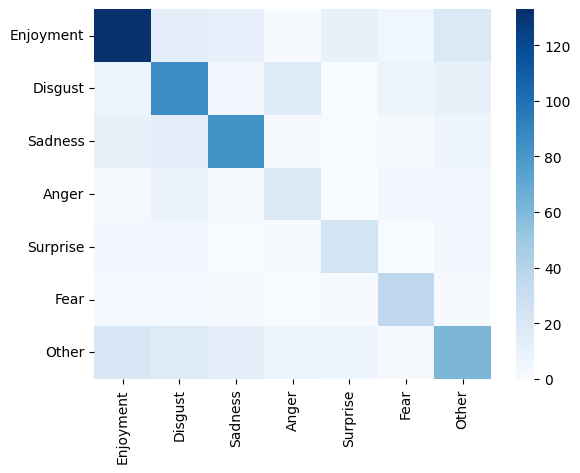

In [32]:
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, cmap="Blues", xticklabels = class_names, yticklabels = class_names);

## Wrong Predicted Label

In [33]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

wrong_arr, wrong_label = check_wrong(real_values, predicts)
print(f'Total wrong: {len(wrong_arr)}')
a = np.arange(len(wrong_arr))
np.random.shuffle(a)
for i in range(15):
    print('-'*50)
    print(test_df.iloc[wrong_arr[a[i]]].Sentence)
    print(f'Predicted:  ({class_names[wrong_label[a[i]]]})\nReal label: ({class_names[real_values[wrong_arr[a[i]]]]})')

Total wrong: 251
--------------------------------------------------
xàm bà cố luôn ??????
Predicted:  (Fear)
Real label: (Enjoyment)
--------------------------------------------------
có ai như tao vô đọc bình luận 🤣 tao cười tao xĩu
Predicted:  (Surprise)
Real label: (Enjoyment)
--------------------------------------------------
bà mẹ nó giật mình
Predicted:  (Disgust)
Real label: (Other)
--------------------------------------------------
tinh trùng đâu lắm thế
Predicted:  (Sadness)
Real label: (Other)
--------------------------------------------------
per không lấy được vợ thì có thể đi tâp gym đêt lấy chồng 😁😁
Predicted:  (Anger)
Real label: (Disgust)
--------------------------------------------------
nhất định sẽ làm được
Predicted:  (Enjoyment)
Real label: (Other)
--------------------------------------------------
tao tát cho bây giờ đấy
Predicted:  (Sadness)
Real label: (Enjoyment)
--------------------------------------------------
nó cứ sai sai thế nào ấy
Predicted:  (Other)
Rea

## Inference

In [44]:
def infer(text, tokenizer, max_len=MAX_LEN):
    clean_text = text_preprocess(text)
    encoded_review = tokenizer.encode_plus(
        clean_text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Clean text: {clean_text}')
    print(f'Sentiment: {class_names[y_pred]}')